# Strategizing the Best Neighbourhood In Toronto City for Gyms

### Import Data from census CSV files

In [1]:
import pandas as pd
import numpy as np

### Load data and store in respective dataframes

In [2]:
# load total population of each Toronto neighbourhood
pop_path = pd.read_csv('population.csv')
df_pop = pd.DataFrame(pop_path)
df_pop.drop(['Neighbourhood Id'], axis=1, inplace=True)

# load population of Gym going population in Toronto neighbourhoods
age = pd.read_csv('age.csv')
df_age1 = pd.DataFrame(age)
df_age = df_age1[['Neighbourhood','Age(15-55)']]
df_age


# load household income of each Toronto neighbourhood
income_path = pd.read_csv('income.csv')
df_income = pd.DataFrame(income_path)
df_income.drop(['Neighbourhood Id'], axis=1, inplace=True)

print("{}, {}, {}".format(df_age.shape[1], df_pop.shape[1], df_income.shape[1]))


2, 2, 2


### Merge the three dataframes 

In [3]:
from functools import reduce
dfs = [df_pop, df_age, df_income]
df_census = reduce(lambda left,right: pd.merge(left,right,on='Neighbourhood'), dfs)
df_census.rename(columns={'After-Tax Household Income': 'Household Income'}, inplace=True)
df_census

,Neighbourhood,Total Population,Age(15-55),Household Income
0,West Humber-Clairville,33312.0,19290,59703.0
1,Mount Olive-Silverstone-Jamestown,32954.0,18855,46986.0
2,Thistletown-Beaumond Heights,10360.0,5570,57522.0
3,Rexdale-Kipling,10529.0,5655,51194.0
4,Elms-Old Rexdale,9456.0,5140,49425.0
...,...,...,...,...
135,West Hill,27392.0,14715,46803.0
136,Woburn,53485.0,29605,47908.0
137,Eglinton East,22776.0,12310,42790.0
138,Scarborough Village,16724.0,9045,40181.0


### Merging geographical data

In [4]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [5]:
df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]

df = df[df.Borough!='Not assigned']
df = pd.merge(df, df_geo, left_on='Postcode', right_on='Postal Code').drop(['Postal Code', 'Postcode', 'Borough'], axis=1)
df = pd.merge(df, df_census, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighbourhood,Latitude,Longitude,Total Population,Age(15-55),Household Income
0,Victoria Village,43.725882,-79.315572,17510.0,9200.0,43743.0
1,Rouge,43.806686,-79.194353,46496.0,25210.0,72784.0
2,Malvern,43.806686,-79.194353,43794.0,24485.0,53425.0
3,Highland Creek,43.784535,-79.160497,12494.0,6545.0,87321.0
4,Flemingdon Park,43.725900,-79.340923,21933.0,12245.0,43511.0


### Get the percentage of Gym Going People in the total population

In [6]:
df['Percentage of Gym going people'] = df['Age(15-55)'] / df['Total Population'] * 100
df.drop(['Total Population', 'Age(15-55)'], axis=1, inplace=True)
df.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Gym going people
0,Victoria Village,43.725882,-79.315572,43743.0,52.541405
1,Rouge,43.806686,-79.194353,72784.0,54.219718
2,Malvern,43.806686,-79.194353,53425.0,55.909485
3,Highland Creek,43.784535,-79.160497,87321.0,52.385145
4,Flemingdon Park,43.725900,-79.340923,43511.0,55.829116


### Create a Folium map

In [7]:
# get location of Toronto using geopy
from geopy.geocoders import Nominatim
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [8]:
# Folium mapping
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

In [9]:
map_Toronto.save("toronto_map.html")

### Explore the neighbourhood using the Foursquare API

In [10]:
#@title
# define Foursquare API credentials and version
CLIENT_ID = 'O3UHS1WHTUPGOMNULUPY15042K1BT2WDCAZ3FGUFZ4LEHH43' # your Foursquare ID
CLIENT_SECRET = 'Z4QJCOBA2TAB2TIUM1TB41C2LSN1X4B5B01ISZIUL33O1HQG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Get the top 100 venues that are in Toronto within a radius of 1500 meters

In [11]:
import requests
LIMIT = 100
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)                         

In [12]:
# run the function above to each neighborhood and create a new dataframe called manhattan_venues
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'])

toronto_venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
2,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
3,Victoria Village,43.725882,-79.315572,Jatujak,43.736208,-79.307668,Thai Restaurant
4,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
...,...,...,...,...,...,...,...
1795,Long Branch,43.602414,-79.543484,The Beer Store,43.594755,-79.533663,Beer Store
1796,Long Branch,43.602414,-79.543484,OUTFRONT Media Canada,43.604357,-79.532706,Print Shop
1797,Long Branch,43.602414,-79.543484,Connorvale Park,43.607201,-79.530702,Park
1798,Long Branch,43.602414,-79.543484,Long Branch TTC Loop,43.591783,-79.544123,Light Rail Station


Check how many venues were returned for each neighbourhood

In [13]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,75,75,75,75,75,75
Alderwood,45,45,45,45,45,45
Bathurst Manor,39,39,39,39,39,39
Bayview Village,15,15,15,15,15,15
Cliffcrest,42,42,42,42,42,42
Dorset Park,58,58,58,58,58,58
Flemingdon Park,82,82,82,82,82,82
Forest Hill North,100,100,100,100,100,100
Guildwood,31,31,31,31,31,31


### Analyze each neighbourhood with One Hot Encoding

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighbourhood to column back to data frame
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# move neighbourhood column to the first column
cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.loc[:,cols]
toronto_onehot

,Neighbourhood,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1796,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1797,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1798,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group rows by neighbourhood and by taking the mean of the frequency of occurrence of gyms

In [36]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Gym']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

### Plotting a bar graph to showcase the frequency distribution of Gyms in each neighbourhood.

In [ ]:
# sort by descending order
toronto_grouped.sort_values(by='Gym', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
toronto_grouped.plot(kind='bar', figsize=(15,5))
plt.title('Mean Frequency of Gyms in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Gyms')

plt.show()

### Plotting a bar graph to illustrate the distribution of Gym going population group in each neighbourhood

In [ ]:
df_age = df[['Neighbourhood', 'Percentage of Gym going people']].set_index('Neighbourhood')

# sort by descending order
df_age.sort_values(by='Percentage of Gym going people', ascending=False, inplace=True)

#plot bar graph
df_age.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Gym Going Aged People in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of Gym Going Aged People')

plt.show()

### Plotting a bar graph to illustrate the distribution of income groups in each neighbourhood

In [ ]:
df_income = df[['Neighbourhood', 'Household Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='Household Income', ascending=False, inplace=True)

#plot bar graph
df_income.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Median Household Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Median Household Income')

plt.show()

### Finalise a dataframe for clustering

In [19]:
# merge df with toronto_grouped
df_final = pd.merge(df, toronto_grouped, on='Neighbourhood')

In [20]:
df_final.head()

,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Gym going people,Gym
0,Victoria Village,43.725882,-79.315572,43743.0,52.541405,0.074074
1,Rouge,43.806686,-79.194353,72784.0,54.219718,0.000000
2,Malvern,43.806686,-79.194353,53425.0,55.909485,0.000000
3,Highland Creek,43.784535,-79.160497,87321.0,52.385145,0.100000
4,Flemingdon Park,43.725900,-79.340923,43511.0,55.829116,0.060976


## Cluster Neighbourhoods

#### Normalizing over the standard deviation
Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use __StandardScaler()__ to normalize our dataset.

In [21]:
from sklearn.preprocessing import StandardScaler
X = df_final.values[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.76318401, -0.54522438,  2.63456151],
       [ 1.89181483, -0.19341811, -0.62649463],
       [ 0.12196797,  0.16078925, -0.62649463],
       [ 3.22082273, -0.57797946,  3.77593116],
       [-0.78439402,  0.14394231,  2.05791134],
       [-0.25953784,  1.0124019 , -0.15311551],
       [ 1.11591265, -2.09486345,  0.53203847],
       [ 1.4250119 , -2.18449086, -0.62649463],
       [-0.18484571, -0.11422014, -0.62649463],
       [-0.48343137, -0.29815499, -0.62649463],
       [ 1.72478605, -0.22118317, -0.62649463],
       [-0.38240958,  0.043923  ,  0.74926343],
       [ 0.51115327, -1.37132365, -0.62649463],
       [-0.09278332, -0.20833537,  0.5023325 ],
       [-1.22925557, -0.16332589,  0.32026361],
       [-1.08883072, -0.22187738, -0.62649463],
       [-0.40517377,  2.27304644,  0.07230312],
       [ 0.03913925,  3.24740262, -0.18625205],
       [-0.83376213,  0.26587859, -0.62649463],
       [-0.94301194, -0.18000373, -0.62649463],
       [ 0.54278543,  0.99609737, -0.626

In [22]:
df_normalized = pd.DataFrame(Clus_dataSet)
df_normalized.rename(columns={0:'Household Income', 1:'% Gym going people', 2:'Gym'}, inplace=True)
df_normalized.head()

,Household Income,% Gym going people,Gym
0,-0.763184,-0.545224,2.634562
1,1.891815,-0.193418,-0.626495
2,0.121968,0.160789,-0.626495
3,3.220823,-0.577979,3.775931
4,-0.784394,0.143942,2.057911


### Finding the optimal number of clusters, k
So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.



In [ ]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalized)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))

plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA23502CC0>,
                 k=None, model=None)

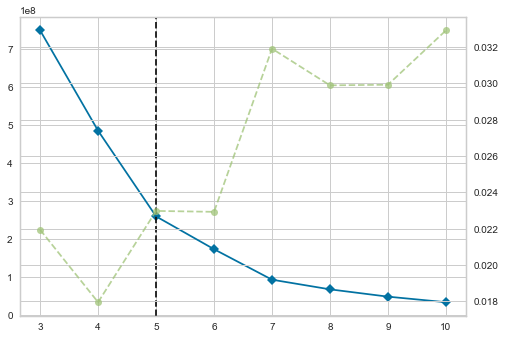

In [24]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))

visualizer.fit(X)

visualizer

## Clustering the Toronto Neighborhood Using K-Means with K = 5

In [25]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 1, 2, 4, 3, 0, 0, 1, 1])

Create a new dataframe that includes the cluster

In [26]:
df_normalized.drop(['Household Income', '% Gym going people'], axis=1, inplace=True)
df_clustered = pd.merge(df, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

### Visulize the clusters on a map

In [27]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
map_clusters.save("clusters.html")

## Examine clusters

### Cluster 0

In [29]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Gym going people,Gym
1,0,Rouge,43.806686,-79.194353,72784.0,54.219718,-0.626495
6,0,Markland Wood,43.643515,-79.577201,64297.0,45.148759,0.532038
7,0,Guildwood,43.763573,-79.188711,67678.0,44.721186,-0.626495
10,0,The Beaches,43.676357,-79.293031,70957.0,54.087263,-0.626495
12,0,Hillcrest Village,43.803762,-79.363452,57682.0,48.600449,-0.626495
22,0,Humber Summit,43.756303,-79.565963,53272.0,52.955863,-0.626495
23,0,Cliffcrest,43.716316,-79.239476,60384.0,51.553185,-0.626495
30,0,Agincourt North,43.815252,-79.284577,55893.0,51.557723,-0.626495
31,0,Milliken,43.815252,-79.284577,55464.0,51.783833,-0.626495
33,0,Alderwood,43.602414,-79.543484,61402.0,53.550689,0.351822


### Cluster 1

In [30]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Gym going people,Gym
2,1,Malvern,43.806686,-79.194353,53425.0,55.909485,-0.626495
8,1,Morningside,43.763573,-79.188711,50069.0,54.597537,-0.626495
9,1,West Hill,43.763573,-79.188711,46803.0,53.720064,-0.626495
11,1,Woburn,43.770992,-79.216917,47908.0,55.351968,0.749263
13,1,Bathurst Manor,43.754328,-79.442259,51076.0,54.148554,0.502332
14,1,Thorncliffe Park,43.705369,-79.349372,38645.0,54.363275,0.320264
15,1,Scarborough Village,43.744734,-79.239476,40181.0,54.083951,-0.626495
18,1,Ionview,43.727929,-79.262029,42971.0,56.410820,-0.626495
19,1,Kennedy Park,43.727929,-79.262029,41776.0,54.283712,-0.626495
21,1,Oakridge,43.711112,-79.284577,32079.0,55.832430,-0.626495


### Cluster 2

In [31]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Gym going people,Gym
3,2,Highland Creek,43.784535,-79.160497,87321.0,52.385145,3.775931


In [32]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Gym going people,Gym
5,3,Humewood-Cedarvale,43.693781,-79.428191,49252.0,59.972155,-0.153116
16,3,Henry Farm,43.778517,-79.346556,47659.0,65.986135,0.072303
17,3,Little Portugal,43.647927,-79.419750,52519.0,70.634360,-0.186252
20,3,Bayview Village,43.786947,-79.385975,58028.0,59.894373,-0.626495
29,3,Roncesvalles,43.648960,-79.456325,46883.0,62.074262,-0.186252


In [33]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Latitude,Longitude,Household Income,Percentage of Gym going people,Gym
0,4,Victoria Village,43.725882,-79.315572,43743.0,52.541405,2.634562
4,4,Flemingdon Park,43.725900,-79.340923,43511.0,55.829116,2.057911
